In [1]:
import geopandas as gpd

In [2]:
df_routes = gpd.read_file('export.geojson')

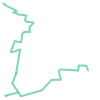

In [3]:
df_routes['geometry'][0]

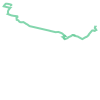

In [4]:
df_routes['geometry'][1]

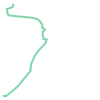

In [5]:
df_routes['geometry'][2]

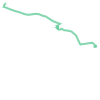

In [6]:
df_routes['geometry'][3]

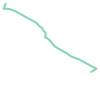

In [7]:
df_routes['geometry'][4]

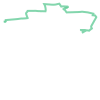

In [8]:
df_routes['geometry'][5]

<AxesSubplot:>

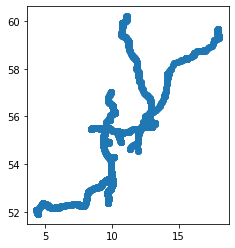

In [9]:
df_routes.plot()